In [83]:

import price_data as price
import chart
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [84]:
class Trade:
    def __init__(self,unix,side,tp,entry,sl):
        self.unix=unix
        self.side=side
        self.tp=tp
        self.sl=sl
        self.entry=entry

    def __str__(self):
        return " % s, tp: % s, entry: % s, sl: % s " % (self.side, self.tp, self.entry, self.sl)
    
class MeanReversionTrade:
    def __init__(self,time ,side,entry,sl):
        self.time=time
        self.side=side
        self.sl=sl
        self.entry=entry
        self.risk=abs(self.sl/self.entry -1 )
    def __str__(self):
        return " % s, tp: % s, entry: % s, sl: % s , risking: % s %" % (self.side, self.tp, self.entry, self.sl, self.risk)
    def check_exit(self):
        pass


def check_engulfing(candle1,candle2):
    if candle1['close']<candle1['open'] and candle2['close']>candle2['open'] and abs(candle2['close']-candle2['open'])>abs(candle1['close']-candle1['open']):
        return 'bullish'
    elif candle1['close']>candle1['open'] and candle2['close']<candle2['open'] and abs(candle2['close']-candle2['open'])>abs(candle1['close']-candle1['open']):
        return 'bearish'
    else:
        return 'not engulfing'

def price_hit(candle,price):
    return candle['high']>price and candle['low']<price

def check_position_close(candle,tp,sl):
    outcome=None
    if price_hit(candle,tp):
        outcome=True # trade successful
    elif price_hit(candle,sl):
        outcome=False
    return outcome!=None, outcome

def read_data(filename):
    raw=pd.read_csv('data/'+filename)
    timestamps=raw['unix']
    for i in range(len(timestamps)):
        if np.log10(timestamps.iloc[i])<12:
            raw.loc[i,'unix']=timestamps[i]*1000
    return raw.sort_values(by=['unix'], ignore_index=True)



In [85]:
minute_csv=read_data('Bitfinex_BTCUSD_minute.csv')
minute_raw=price.get_price_data('1m',data=minute_csv)


In [86]:
def backtest_scalp(data, ema_period):
    net_profit=0
    trade_capital=300
    ema=chart.get_ema(data,ema_period)
    rsi=chart.get_rsi(data,20)
    atr=chart.get_atr(data,14)
    starting_index=ema.index.values.min()
    trimmed_data=data.iloc[starting_index:]
    rsi=rsi.iloc[starting_index:]
    atr=atr.iloc[starting_index:]

    trades=[]
    outcomes=[]
    profits=[]
    for i in range(2,len(trimmed_data)):
        current_candle=trimmed_data.iloc[i]

        if not(len(trades)==0):
            #check if positions should be closed
            for trade in trades:
                close_position, outcome=check_position_close(current_candle,trade.tp,trade.sl)
                if close_position:
                    print('close trade: ', trade, outcome)
                    trades.remove(trade)
                    outcomes.append(outcome)
                    if trade.side=='buy':
                        if outcome:
                            profit=trade.tp/trade.entry-1
                        else:
                            profit=trade.sl/trade.entry-1
                    elif trade.side=='sell':
                        if outcome:
                            profit=1-trade.tp/trade.entry
                        else:
                            profit=1-trade.sl/trade.entry
                    net_profit=trade_capital*profit+net_profit
                    profits.append(profit)
                    


        current_ema=ema.iloc[i]
        current_rsi=rsi.iloc[i]
        current_atr=atr.iloc[i]
        candle1=trimmed_data.iloc[i-2]
        candle2=trimmed_data.iloc[i-1]
        engulfing=check_engulfing(candle1,candle2)

        if engulfing=='bullish' and (current_candle['open']>current_ema).all() and (current_rsi>60).all() and len(trades)<4:
            entry=current_candle['open']
            sl=round(current_candle['open']-2*current_atr,0)
            tp=round(current_candle['open']+4*current_atr,0)
            if abs(sl/entry - 1)<0.002:
                trade=Trade('buy',tp,entry,sl)
                trades.append(trade)
                print(pd.to_datetime(current_candle['unix'], unit='ms'), trade)
        elif engulfing=='bearish' and (current_candle['open']<current_ema).all() and (current_rsi<40).all() and len(trades)<4:
            entry=current_candle['open']
            sl=round(current_candle['open']+2*current_atr,0)
            tp=round(current_candle['open']-4*current_atr,0)
            if abs(sl/entry - 1)<0.002:
                trade=Trade('sell',tp,entry,sl)
                trades.append(trade)
                print(pd.to_datetime(current_candle['unix'], unit='ms'), trade)
    return len(outcomes), np.sum(outcomes)/len(outcomes), net_profit

# trade_capital=300

# trimmed_data_trimmed=minute_raw.iloc[-5000:].reset_index(drop=True)
# results=[]
# for ma in range(100,300,10):
#print('testing')
# backtest_scalp(minute_trimmed,200)
#     results.append([trades,ma,success_rate, net_profit])

# results_df=pd.DataFrame(np.array(results),columns=['trades','ma','success_rate','net_profit'])
# results_df

2283.9 unix     1.627448e+12
ma       2.271515e+03
upper    2.329917e+03
lower    2.213113e+03
Name: 1500, dtype: float64


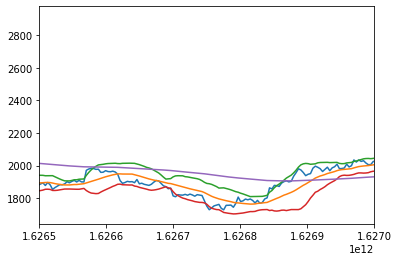

In [87]:
hourly=price.get_price_data('1h',symbol='ETH/USD')
ema=chart.get_ema(hourly,200,False)
bollinger= chart.get_bb(hourly,20,2)
plt.plot(hourly['unix'],hourly['open'])
plt.plot(bollinger['unix'],bollinger['ma'])
plt.plot(bollinger['unix'],bollinger['upper'])
plt.plot(bollinger['unix'],bollinger['lower'])
plt.plot(ema['unix'],ema['value'])
plt.xlim(1.6265*(10**12),1.627*(10**12))
print(hourly['open'].iloc[-1], bollinger.iloc[-1])

In [152]:
def backtest_bollinger_bands(candles,ma_period, bb_period,multiple,atr_period):
    equity=1
    state='neutral'
    trades=[]
    active_trade=None
    long_term_ema=chart.get_ema(candles,ma_period, False)
    ma_gradient=chart.get_gradient(long_term_ema)
    min_timestamp=long_term_ema['unix'].min()
    bollinger_band= chart.get_bb(candles,bb_period,multiple)
    atr=chart.get_atr(candles,atr_period)
    trimmed_candles=candles.loc[candles['unix']>=min_timestamp]
    bollinger_band=bollinger_band[bollinger_band['unix']>=min_timestamp]
    for i in range(0,len(trimmed_candles)):
        current_candle=trimmed_candles.iloc[i]
        time=current_candle['unix']
        current_price=current_candle['open']
        previous_two_opens=trimmed_candles[i-2:i]
        current_ema=long_term_ema.iloc[i]
        current_upper=bollinger_band['upper'].iloc[i]
        current_lower=bollinger_band['lower'].iloc[i]
        current_atr=atr.loc[time]
        current_gradient=ma_gradient.loc[time]
        if active_trade!=None:
            #check trade conditions
            if (active_trade.side=='buy' and (current_price<active_trade.sl).all()) or (active_trade.side=='sell' and (current_price>active_trade.sl).all()):
                #sl hit
                equity=equity*(1-active_trade.risk)
                trades.append([active_trade.time,active_trade.side,active_trade.entry,active_trade.sl,active_trade.risk,False,0, equity])
                state='neutral'
                active_trade=None
            elif (active_trade.side=='buy' and (current_price>current_upper).all()):
                #long successful
                profit=current_price/active_trade.entry
                equity=equity*profit
                trades.append([active_trade.time,active_trade.side,active_trade.entry,active_trade.sl,active_trade.risk,True,profit-1, equity])
                state='neutral'
                active_trade=None
            elif (active_trade.side=='sell' and (current_price<current_lower).all()):
                #short successful
                profit=1-current_price/active_trade.entry
                equity=equity*(1+profit)
                trades.append([active_trade.time,active_trade.side,active_trade.entry,active_trade.sl,active_trade.risk,True,profit, equity])
                state='neutral'
                active_trade=None
        if (current_price>current_upper).all() and (current_gradient<0).all() and state=='neutral':
            
            entry=current_price
            sl=entry+current_atr
            risk=abs(sl/entry -1 )
            if (risk<=0.03):
                active_trade=MeanReversionTrade(pd.to_datetime(time, unit='ms'),'sell',entry,sl)
                state='short'
        elif (current_price<current_lower).all() and (current_gradient>0).all() and state=='neutral':
            
            entry=current_price
            sl=entry-current_atr
            risk=abs(sl/entry -1 )
            if (risk<=0.03):
                active_trade=MeanReversionTrade(pd.to_datetime(time, unit='ms'),'buy',entry,sl)
                state='long'
    if len(trades)==0:
        return pd.DataFrame([]), equity
    return pd.DataFrame(np.array(trades), columns=['datetime','side','entry','sl','risk','outcome','profit', 'equity']), equity

hourly_csv=read_data('Bitfinex_ETHUSD_1h.csv')
hourly_raw=price.get_price_data('1m',data=hourly_csv)
        


In [92]:
# results_df=pd.DataFrame(np.array(optimisation_results),columns=['long_term_period','bb_period','multiple','atr_period','win_rate','equity','risk/reward'])
# results_df=results_df[results_df['win_rate']>0.55]
# results_df=results_df[results_df['equity']>1.5]
# results_df=results_df[results_df['risk/reward']>1.5]
# results_df

In [101]:
results_df=pd.read_csv('data/result_mean_reversion.csv')
results_df

,long_term_period,bb_period,multiple,atr_period,win_rate,equity,risk/reward
0,50,6,1.4,4,0.656716,1.749312,1.603866
1,50,6,1.4,6,0.632353,1.740104,1.677588
2,50,6,1.4,8,0.656716,1.744592,1.536730
3,50,6,1.4,10,0.647059,1.708268,1.511729
4,50,6,1.4,12,0.656716,1.727233,1.502004
...,...,...,...,...,...,...,...
1143,240,8,1.3,18,0.583333,1.693871,1.533099
1144,240,8,1.3,20,0.583333,1.693818,1.535236
1145,240,17,1.7,4,0.566667,1.526462,2.242333
1146,240,17,1.8,4,0.571429,1.540353,2.285433


In [102]:
results_df=results_df.loc[results_df['equity']>1.9]
results_df=results_df.loc[results_df['win_rate']>0.6]
results_df=results_df.loc[results_df['risk/reward']>1.55]
results_df

,long_term_period,bb_period,multiple,atr_period,win_rate,equity,risk/reward
701,150,8,1.3,14,0.608108,1.904115,1.566583
794,160,8,1.3,14,0.608108,1.929593,1.576975
795,160,8,1.3,16,0.608108,1.921319,1.581072
796,160,8,1.3,18,0.608108,1.920497,1.575105
797,160,8,1.3,20,0.608108,1.918486,1.577748


In [150]:
recent_hourly=price.get_price_data('1h',symbol='ETH/USD')
long_term_period=160
bb_period=8
multiple=1.3
atr_period=16
historical_test_result, final_equity = backtest_bollinger_bands(recent_hourly,long_term_period,bb_period,multiple,atr_period)
risk_reward=(historical_test_result['profit'].divide(historical_test_result['risk']))
risk_reward[risk_reward==0]=np.nan
mean_risk_reward=np.nanmean(risk_reward)
win_rate=np.sum(historical_test_result['outcome'])/len(historical_test_result)
print(win_rate, final_equity, mean_risk_reward)

0.6052631578947368 1.9376925045963833 1.5952465596559406


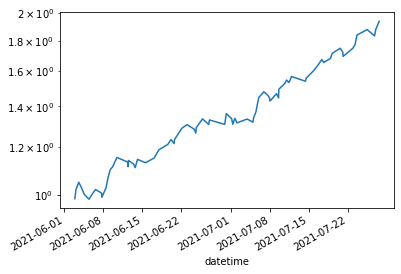

In [151]:
ax=historical_test_result.plot(x='datetime', y='equity', logy=True, legend=False)

(array([589., 664., 152.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12]),
 <BarContainer object of 12 artists>)

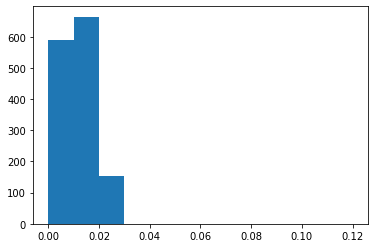

In [147]:
plt.hist(pd.to_numeric(historical_test_result['risk']), range=(0,0.12), bins=12)